# Exploratory data analysis

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 2000) # since we have a lot of features
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [3]:
''' Import data '''

DATA_DIR = 'data'
train_file = os.path.join(DATA_DIR, 'train.csv')
test_file = os.path.join(DATA_DIR, 'test.csv')
submission_file = os.path.join(DATA_DIR, 'sample_submission.csv')

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

X = train.drop(columns=['y', 'sample_id'])
y = train.y
X_test = test.drop(columns=['sample_id'])

X_all = X.append(X_test)

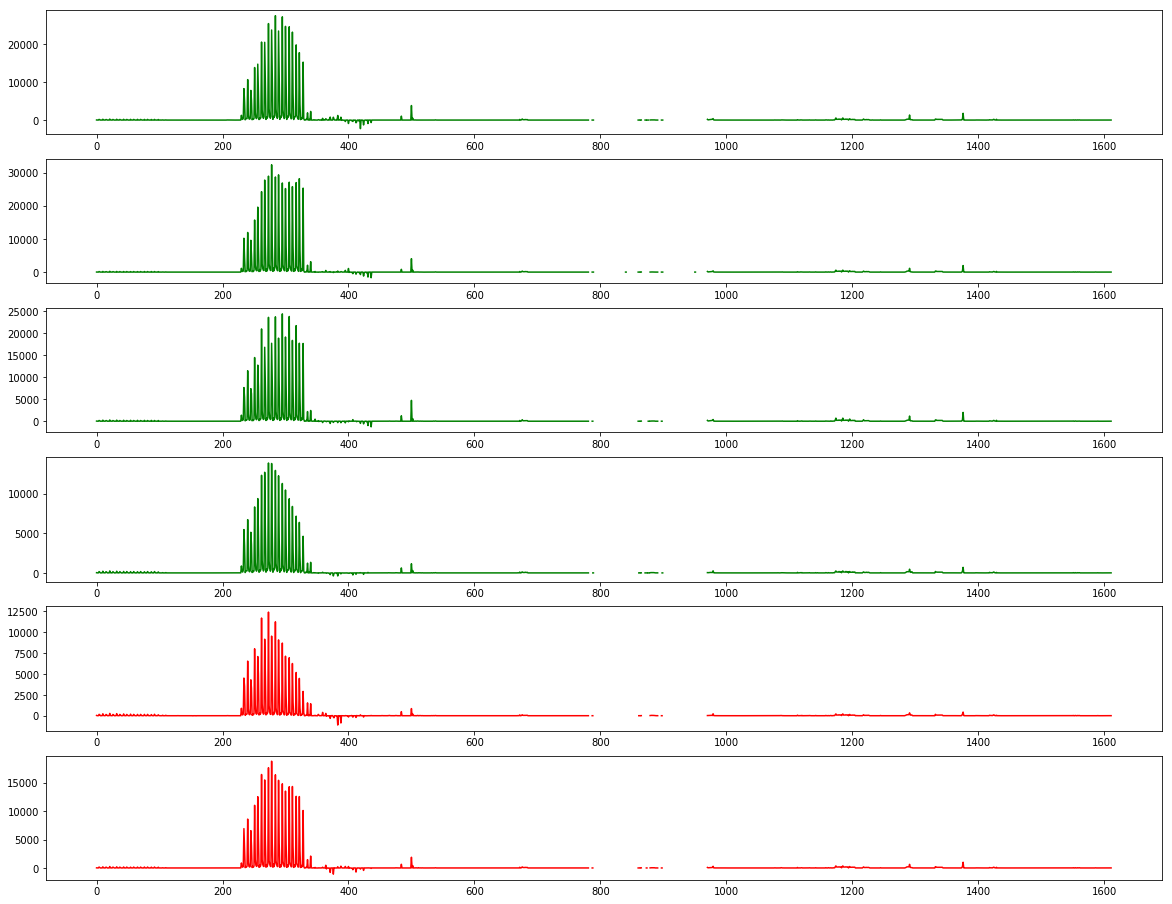

In [3]:
fig, ax = plt.subplots(nrows=6, figsize=(20, 16))

for i in range(3):
    if np.equal(train.iloc[i,-1], 1.0):
        color='g'
    else:
        color='r'
    ax[i].plot(train.iloc[i,1:-1].values.T.reshape(-1,), c=color)

for i in range(3,6):
    if np.equal(train.iloc[i,-1], 1.0):
        color='g'
    else:
        color='r'
    ax[i].plot(train.iloc[1094-5+i,1:-1].values.T.reshape(-1,), c=color)

## Plot all feature for a couple of samples

### Train set

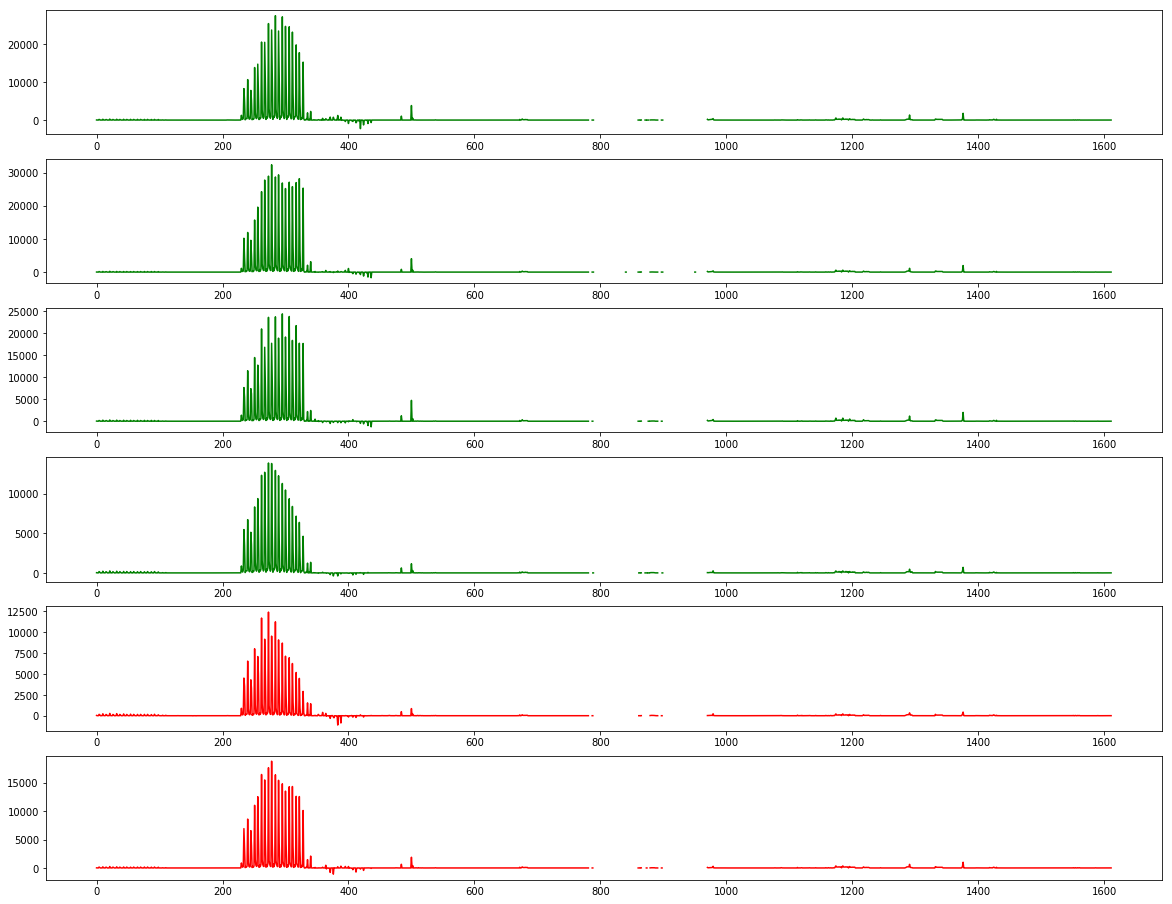

In [5]:
fig, ax = plt.subplots(nrows=6, figsize=(20, 16))

for i in range(3):
    if np.equal(train.iloc[i,-1], 1.0):
        color='g'
    else:
        color='r'
    ax[i].plot(train.iloc[i,1:-1].values.T.reshape(-1,), c=color)

for i in range(3,6):
    if np.equal(train.iloc[i,-1], 1.0):
        color='g'
    else:
        color='r'
    ax[i].plot(train.iloc[1094-5+i,1:-1].values.T.reshape(-1,), c=color)

### Test set

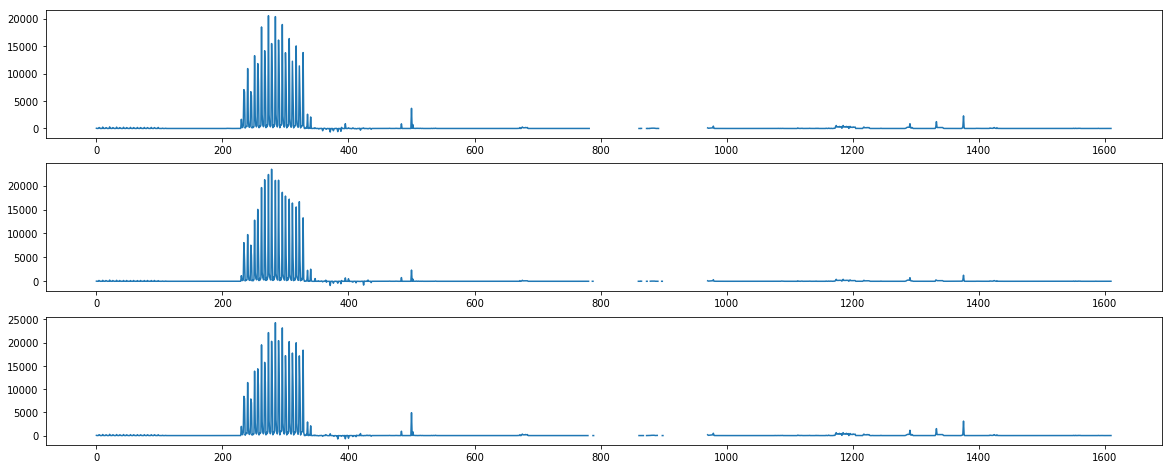

In [4]:
fig, ax = plt.subplots(nrows=3, figsize=(20, 8))

for i in range(3):
    ax[i].plot(test.iloc[i,1:-1].values.T.reshape(-1,))



Видно, что:
1. фичи в районе 790-1000 содержат непонятные данные - их мы, конечно, закодируем, а на первый бэйзлайн их можно выкинуть.
2. фичи в районе 400 кажутся информативными

### Проверяем изменения в сэмплах по одной переменной.

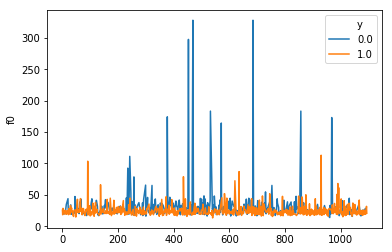

In [6]:
sns.lineplot(x=range(train.shape[0]), y=train['f0'], hue=train['y']);

Не похоже на какую-то временную зависимость. Но, судя по всему, у нас есть выбросы.

Теперь можно заняться нормальным EDA.

## Target distribution

In [7]:
''' Target distribution '''

train.y.value_counts()

1.0    671
0.0    424
Name: y, dtype: int64

Неплохо, практически сбалансированный датасет. Посмотрим, меняется ли распределение целевой переменной в разных участках датасета.

Mean y: 0.6128


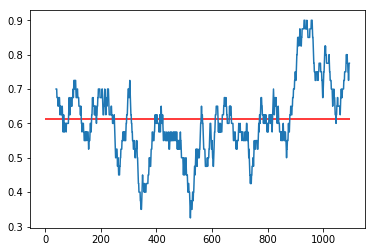

In [8]:
print("Mean y: %.4f" % train.y.mean())

plt.plot(train.y.rolling(40).mean())
plt.hlines(train.y.mean(), xmin=0, xmax=train.shape[0], color='r');

Окей, на этом месте можно определиться со схемой валидации - RepeatedStratifiedKFold с дефолтными сплитами (n_splits=5, repeats=10).

## Поисследуем фичи

#### В каких фичах какой % NaN?

72
353


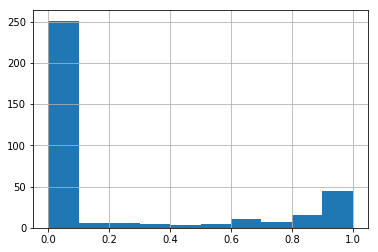

In [9]:
''' Let's finally deal with na columns '''

from sklearn.preprocessing import FunctionTransformer

na_cols = X_all[X_all.isna().any()[lambda x: x].index].isna().agg(['sum', 'count']).T

all_na_cols = na_cols[na_cols['sum'] == na_cols['count']].index
has_na_cols = na_cols.T.drop(columns=all_na_cols.values).T
has_na_cols['perc'] = has_na_cols['sum']/has_na_cols['count']

print(all_na_cols.shape[0])
print(has_na_cols.shape[0])

has_na_cols['perc'].hist();

В датасете находится 72 переменных, состоящих полностью из NaN. Кроме того, в нем также находится 353 переменные, содержащие NaN. Большинство этих переменных содержит 10% и меньше NaN, лишь у 90 колонок доля NaN больше 30%. Заполняем NaN средним + добавляем бинарную фичу "был NaN/не был NaN".

### Inf

Index([], dtype='object')
0


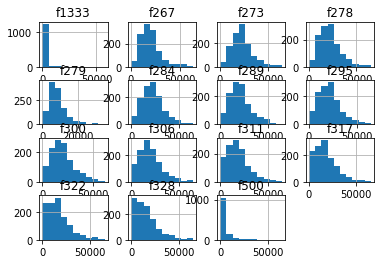

In [10]:
''' Let's deal with infinite values '''

pos_inf_cols = X_all.fillna(0).replace([np.inf], 
                                       np.nan).isna().any()[lambda x: x].index
pos_inf_cols = X_all[pos_inf_cols].replace([np.inf], 
                                           np.nan).isna().agg(['sum', 'count']).T
neg_inf_cols = X_all.fillna(0).replace([-np.inf],
                                       np.nan).isna().any()[lambda x: x].index

print(neg_inf_cols)
print(np.isin(na_cols.index.values, pos_inf_cols.index.values).sum())

X_all[pos_inf_cols.index.values].replace(np.inf, np.nan).hist();

Лишь в 15 переменных содержатся значения inf, причем все они имеют очень большие максимальные значения. Вероятно, Inf символизирует зашкаливание прибора? Эти переменные не пересекаются с теми, которые содержат NaN. Заполним inf значением, вдвое превышающим максимум.

Значений -inf не найдено -_- .

### Здесь должно было быть исследование на поиск колонок с нулевой дисперсией, но есть только вывод

В данных кроме всего прочего содержится 125 переменных, содержащих только 1 значение. Их мы тоже удалим. Преобразования над NaN и Inf не породили дополнительных колонок с нулевой дисперсией.

### Фичи с высокой корреляцией

In [4]:
''' Дальше нам понадобятся функции препроцессинга '''

''' Gather all preprocessing functions '''

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import bisect
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


''' 1 - divide to training and holdout datasets '''

X_train, X_hold, y_train, y_hold = train_test_split(X, y, random_state=3, test_size=0.3)

''' 2 - define the same validation scheme for all models '''

skf = RepeatedStratifiedKFold(n_repeats=5, random_state=17)


''' Function 1 - delete all columns with NaN or Inf '''
columns_to_keep = X_all.replace([np.inf, -np.inf], np.nan).dropna(axis=1).columns

def del_nan(x):
    return x[columns_to_keep]
delete_nan = FunctionTransformer(del_nan, validate=False)


''' Function 2 - delete NaN-only columns '''

na_cols = X_all[X_all.isna().any()[lambda x: x].index].isna().agg(['sum', 'count']).T

all_na_cols = na_cols[na_cols['sum'] == na_cols['count']]

def drop_all_na(X):
    ''' Here we drop all columns which consist of NaN only '''
    idx = all_na_cols.index.values
    return X.drop(columns=idx)

drop_all_na_f = FunctionTransformer(drop_all_na, validate=False)


''' Function 3 - replace NaN '''

has_na_cols = na_cols.T.drop(columns=all_na_cols.index.values).T
has_na_cols['perc'] = has_na_cols['sum']/has_na_cols['count']

'''def replace_na(X, add_boolean=True, threshold=0.3):
    Here we apply two filling strategies
            for two types of columns with na:
            % na > threshold - fill with mean
            % na < threshold - fill with 0.
        Plus we add additional columns showing
            if the value was na before transformation.
    X_copy = X.copy()
    cols_less = has_na_cols[has_na_cols['perc'] < threshold].index.values
    cols_more = has_na_cols[has_na_cols['perc'] >= threshold].index.values
    X_less = X_copy[cols_less]
    X_less = X_less.fillna(X_less.mean())
    X_copy[cols_less] = X_less
    X_copy[cols_more] = X_more
    if add_boolean:
        was_na = X[has_na_cols.index.values].isna().astype('int64')
        was_na.columns = was_na.columns.map(lambda x: x + '_na')
        X_copy = pd.concat([X_copy, was_na], axis=1)
    return X_copy'''
    
# I should have checked columns for categorical features before

def replace_na(X, add_boolean=True):
    ''' Here we apply mean filling strategy.
        And add additional columns showing if the values
        was na before transformation.
    '''
    X_copy = X.copy()
    cols = has_na_cols.index.values
    X_c = X_copy[cols]
    X_c = X_c.fillna(X_all.replace([np.inf, -np.inf], np.nan).mean())
    X_copy[cols] = X_c
    if add_boolean:
        was_na = X[has_na_cols.index.values].isna().astype('int64')
        was_na.columns = was_na.columns.map(lambda x: x + '_na')
        X_copy = pd.concat([X_copy, was_na], axis=1)
    return X_copy

replace_na_f = FunctionTransformer(replace_na, validate=False)


''' Function 4 - replace inf '''

pos_inf_cols = X_all.fillna(0).replace([np.inf], 
                                       np.nan).isna().any()[lambda x: x].index
pos_inf_cols = X_all[pos_inf_cols].replace([np.inf], 
                                           np.nan).isna().agg(['sum', 'count']).T
neg_inf_cols = X_all.fillna(0).replace([-np.inf],
                                       np.nan).isna().any()[lambda x: x].index

def fill_inf(X, add_boolean=True, multiplier=2):
    '''
    Here we apply filling strategy for infinite values:
        we replace it with absolute maximum value * multiplier.
    Additionally, we new columns showing if the value
        was infinite before filling.
    '''
    X_copy = X.copy()
    X_pos = X_copy[pos_inf_cols.index.values]
    to_fill = X_pos.replace(np.inf, np.nan).abs().max() * multiplier + 1.0
    X_pos = X_pos.replace(np.inf, np.nan).fillna(to_fill)
    X_copy[pos_inf_cols.index.values] = X_pos
    if add_boolean:
        was_inf = X[pos_inf_cols.index.values].replace(np.inf, np.nan).isna().astype('int64')
        was_inf.columns = was_inf.columns.map(lambda x: x + '_inf')
        X_copy = pd.concat([X_copy, was_inf], axis=1)
    return X_copy

fill_inf_f = FunctionTransformer(fill_inf, validate=False)


''' First block of data cleaning is gathered in one function '''

def pre_proc(X):
    return fill_inf(replace_na(drop_all_na(X)))


''' Function and class 5 - delete zero-variance features '''

w = fill_inf(replace_na(drop_all_na(X_all))).var()
zero_var_cols = w[np.isclose(w, 0)]

def drop_zero_var(X):
    idx = zero_var_cols.index.values
    return X.drop(columns=idx)

drop_zero_var_f = FunctionTransformer(drop_zero_var)

class Drop_zero_var:
    def __init__(self):
        self.zero_var_cols = []
        self.is_fitted = False
        
    def fit(self, X, y=None):
        w = X.var()
        self.zero_var_cols = w[np.isclose(w, 0.0)].index.values
        self.is_fitted = True
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy.drop(columns=self.zero_var_cols)
    
    def fit_transform(self, X, y=None):
        if not self.is_fitted:
            self.fit(X, y)
        return self.transform(X, y)

print(Drop_zero_var().fit_transform(pre_proc(X_train), y_train).shape)

''' Function and class 6 - drop highly correlated features '''

'''
# Here is the function
print(drop_zero_var(pre_proc(X_all)).shape)
corr_matrix = pre_proc(X_all).corr().abs()
print(corr_matrix.shape)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(to_drop))

'''

class Drop_corr:
    def __init__(self, threshold=0.95):
        self.to_drop = []
        self.is_fitted = False
        self.threshold = threshold
        
    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        self.is_fitted = True
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy.drop(columns=self.to_drop)
    
    def fit_transform(self, X, y=None):
        if not self.is_fitted:
            self.fit(X, y)
        return self.transform(X, y)

print(Drop_corr().fit_transform(pre_proc(X_train), y_train).shape)
    
''' Class 7 - encode categorical labels '''

class LE_df:
    def __init__(self, threshold=5):
        self.le_dict = {}
        self.threshold = threshold
        
    def fit(self, X, y=None):
        X_copy = X.copy()
        counts = X_copy.apply(lambda x: x.value_counts().shape[0])
        categorical = X_copy[counts[counts <= self.threshold].index]
        for col in categorical.columns:
            le = LabelEncoder()
            le.fit(categorical[col])
            self.le_dict[col] = le
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.le_dict.keys():
            X_copy[col] = X_copy[col].map(lambda s: -100500 if s not in \
                                          self.le_dict[col].classes_ else s)
            if np.any(X_copy[col]==-100500):
                le_classes = self.le_dict[col].classes_.tolist()
                le_classes.append(-100500)
                self.le_dict[col].classes_ = np.asarray(le_classes)
            X_copy[col] = self.le_dict[col].transform(X_copy[col])
        return X_copy
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

print(LE_df().fit_transform(pre_proc(X_train), y_train).shape)
    
''' Class 8 - target mean encode categorical labels '''

class LOOTME_df:
    ''' Class performs leave-one-out target mean encoding '''
    def __init__(self, threshold=5):
        self.threshold = threshold
        self.tme_dict = {}
        self.is_fitted = False
        
    def fit(self, X, y):
        X_copy = X.copy()
        y_copy = y.copy()
        counts = X_copy.apply(lambda x: x.value_counts().shape[0])
        categorical = X_copy[counts[counts <= self.threshold].index]
        for col in categorical.columns:
            df = pd.concat((X_copy[col], y_copy), axis=1)
            df.columns = ['col', 'y']
            tme = {}
            for value in df['col'].unique():
                y_val = df[df['col'] == value]['y'].values
                col_val = df[df['col'] == value]['col'].values
                loo_mean = np.mean((np.full_like(col_val, y_val.sum()) - y_val) / y_val.shape[0])
                tme[value] = loo_mean
            self.tme_dict[col] = tme
        self.is_fitted = True
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.tme_dict.keys():
            X_copy[col] = X_copy[col].map(lambda s: -100500 if s not in self.tme_dict[col].keys() else s)
            self.tme_dict[col][-100500] = 0.0
            X_copy[col] = X_copy[col].map(self.tme_dict[col])
        return X_copy
        
    
    def fit_transform(self, X, y):
        if not self.is_fitted:
            self.fit(X, y)
        return self.transform(X, y)
    
print(LOOTME_df().fit_transform(pre_proc(X_train), y_train).shape)


''' Class 9 - One Hot Encoding of categorical features '''

class OneHot_df:
    def __init__(self, threshold=5, drop_collinear=False):
        self.threshold = threshold
        self.drop_collinear = drop_collinear
        self.categorical = []
        self.ohe = None
        self.column_names = None
        self.is_fitted = False
        
    def fit(self, X, y=None):
        X_copy = X.copy()
        counts = X_copy.apply(lambda x: x.value_counts().shape[0])
        X_cat = X_copy[counts[(counts <= self.threshold) & (counts > 1)].index]
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe.fit(X_cat)
        self.categorical = X_cat.columns
        self.ohe = ohe
        self.is_fitted = True
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.copy()[self.categorical]
        X_cat_tr = self.ohe.transform(X_cat).toarray()
        if not self.column_names:
            column_names = []
            for i, col in enumerate(self.categorical):
                column_names.extend([col + '_' + str(s) for s in self.ohe.categories_[i]])
            self.column_names = column_names
        X_cat_tr = pd.DataFrame(X_cat_tr, columns=self.column_names, index=X_copy.index)
        X_other = X_copy.drop(columns=self.categorical)
        X_copy = pd.concat([X_other, X_cat_tr], axis=1)
        if self.drop_collinear:
            to_drop = pd.Series(self.column_names, 
        index=self.column_names).apply(lambda x: x.endswith('_0'))[lambda x: x].index
            X_copy.drop(columns=to_drop)
        return X_copy
    
    def fit_transform(self, X, y=None):
        if not self.is_fitted:
            self.fit(X, y)
        return self.transform(X, y)

print(OneHot_df().fit(pre_proc(X_train)).transform(pre_proc(X_hold)).shape)

''' Class 10 - find best normalizing transformation '''

def get_shapiro_p(X):
    _, p = shapiro(X)
    return p

class Find_Trans:
    def __init__(self, threshold=10):
        self.threshold = threshold
        self.pvals = []
        self.numerical = []
        self.is_fitted = False
        self.mms = MinMaxScaler()
        self.trans_dict = {'no': lambda x: x,
                           'x^2': lambda x: np.power(x, 2), 
                           'x^3': lambda x: np.power(x, 3), 
                           'log(x)': lambda x: np.log(x), 
                           #'exp(x)': lambda x: np.exp(x/10), 
                           'sqrt(x)': lambda x: np.sqrt(x)}
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        counts = X_copy.apply(lambda x: x.value_counts().shape[0])
        self.numerical = counts[counts > self.threshold].index.values
        X_numer = X_copy[self.numerical]
        idx = X_numer.index
        X_numer = pd.DataFrame(self.mms.fit_transform(X_numer) + 0.01,
                               columns=self.numerical,
                               index=idx)
        pvals = pd.DataFrame(X_numer.apply(get_shapiro_p), columns=['no'])
        for name in self.trans_dict.keys():
            if name not in pvals.columns:
                pvals[name] = X_numer.apply(self.trans_dict[name]).apply(get_shapiro_p)
        self.pvals = pvals
        self.is_fitted = True
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_numer = X_copy[self.numerical]
        idx = X_numer.index
        X_numer = pd.DataFrame(self.mms.transform(X_numer) + 0.01,
                               columns=self.numerical,
                               index=idx)
        best_transform = self.pvals.idxmax(axis=1)
        best_transform = best_transform.map(self.trans_dict).to_dict()
        X_numer = X_numer.apply(best_transform)
        X_numer = X_numer.fillna(X_numer.min()-1)
        for col in self.numerical:
            X_copy[col] = X_numer[col]
        return X_copy
    
    def fit_transform(self, X, y=None):
        if not self.is_fitted:
            self.fit(X, y)
        return self.transform(X, y)

print(Find_Trans().fit(pre_proc(X_train), y_train).transform(pre_proc(X_hold)).shape)


''' Class 11 - find and drop outliers '''

class DetectOut_df:
    def __init__(self, method='IsolationForest', out_fraction=0.05, 
                 drop=True, random_state=17,
                 kernel='rbf', shrink=True):
        self.method = method
        self.out_fraction = out_fraction
        self.drop = drop
        self.is_fitted = False
        self.random_state = random_state
        self.kernel = kernel
        self.shrink = shrink
        self.model = None
        self.train_set = []
        
    def fit(self, X, y=None):
        if self.method == 'IsolationForest':
            model = IsolationForest(random_state=self.random_state,
                        n_estimators=100,
                        max_features=0.9,
                        contamination=self.out_fraction, #
                        n_jobs=-1,
                        behaviour='new')
        if self.method == 'OneClassSVM':
            model = OneClassSVM(kernel=self.kernel,
                     nu=self.out_fraction,
                     shrinking=self.shrink,
                     gamma='scale'
                    )
        model.fit(X, y)
        self.model = model
        self.is_fitted = True
        self.train_set = X.copy()
        return self
    
    def transform(self, X, y):
        ''' We shouldn't predict any outliers for test set '''
        X_copy = X.copy()
        X_copy['outlier'] = 1
        X_copy['y'] = y.copy()
        if self.train_set.equals(X):
            X_copy['outlier'] = self.model.predict(X)
        if self.drop:
            X_copy = X_copy[X_copy['outlier'] == 1]
            X_copy = X_copy.drop(columns=['outlier'])
        y_copy = X_copy['y']
        X_copy = X_copy.drop(columns=['y'])
        return X_copy, y_copy
    
    def fit_transform(self, X, y):
        if not self.is_fitted:
            self.fit(X, y)
        return self.transform(X, y)
    
print(DetectOut_df().fit_transform(pre_proc(X_train), y_train)[0].shape)

(766, 1777)
(766, 932)
(766, 1908)
(766, 1908)
(329, 2518)
(329, 1908)
(727, 1908)


In [15]:
''' Фичи с высокой корреляцией '''

def pre_proc(X):
    return drop_zero_var(fill_inf(replace_na(drop_all_na(X))))

print(pre_proc(X_all).shape)

corr_matrix = pre_proc(X_all).corr().abs()

#print(corr_matrix.shape)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.94)]

print(len(to_drop))

(1289, 1781)
1007


При пороге в 0.95 по корреляции можно отбросить 977 из 1781 полученных фич, при пороге 0.94 (который реально использовался) - 1007 фич.

### Здесь должны были быть исследования на поиск категориальных фич

В финальных моделях категориальными фичами считали все, в которых количество уникальных значений 5 и менее. Их обрабатывали по одной из трех стратегий:
* Label Encoder - в итоге не использовалась
* Leave-one-out target mean encoding - хорошо подошла "деревянным" моделям и нейронной сети
* Label Encoder + One Hot Encoder - хорошо подошла логистической регрессии.

### Изменение распределений фич

In [17]:
''' Explore feature distributions '''

from sklearn.pipeline import Pipeline

CORR_THRESHOLD = 0.94
CAT_THRESHOLD = 5 # <- and less unique values make feature categorical

pipe_pp = Pipeline([('pre_proc', FunctionTransformer(pre_proc, validate=False)),
                      ('drop_zero_var', Drop_zero_var()),
                      ('drop_corr', Drop_corr(threshold=CORR_THRESHOLD)),
                      ('lootme', LOOTME_df(threshold=CAT_THRESHOLD))])

X_new = pipe_pp.fit_transform(X, y)

print(X_new.shape)

(1095, 771)


(1095, 639)


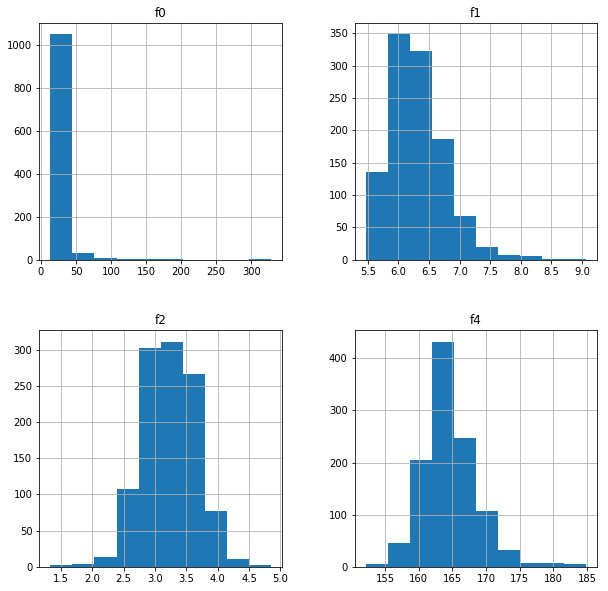

In [18]:
counts = X_new.apply(lambda x: x.value_counts().shape[0])
numerical = counts[counts > CAT_THRESHOLD].index.values
X_n_numer = X_new[numerical]

print(X_n_numer.shape)

X_n_numer.iloc[:, :4].hist(figsize=(10, 10));

Вот так и выглядят фичи - распределения могут быть скошенными влево-вправо, слишком "острыми" и с явными выбросными значениями.

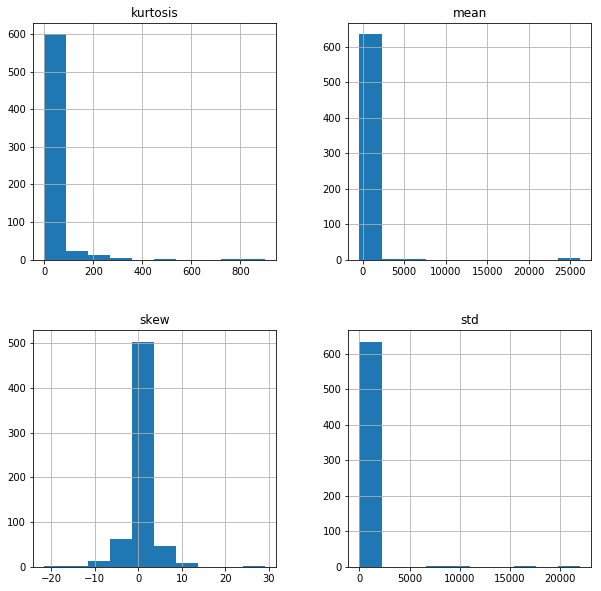

In [19]:
from scipy.stats import skew, kurtosis

X_n_numer.agg(["mean", "std", "skew", "kurtosis"]).T.hist(figsize=(10, 10));

Держим в уме, что nan мы заменяли на среднее, а inf - на максимальное значение * 2 + 1.

Когда смотрим на распределение основных характеристик, то видим:
1. Существуют фичи с диапазоном среднего в районе 25000, есть - около 5000, в основном же среднее гораздо меньше - в районе 0.
2. Стандартное отклонение у фич тоже бывает разное. Есть фичи с очень большим std - около 20000. Возможно, в них много выбросов? Или это эффект замены inf на слишком большое значение?
3. Коэффициент асимметрии в большиства фич в районе 0, но есть в районе 5 и -5, есть в районе 25 - это говорит о том, что у некоторые фичи просто скошены влево или вправо, а есть с очень тяжелыми правыми хвостами.
4. Коэффициент эксцесса у всех в основном положительный - то есть, распределения более "узкие", чем нормальное.



Для "нормализации" фич была использована стратегия поиска преобразования, которое давало бы наибольшее p-value для Шапиро-Вилка теста на нормальность.

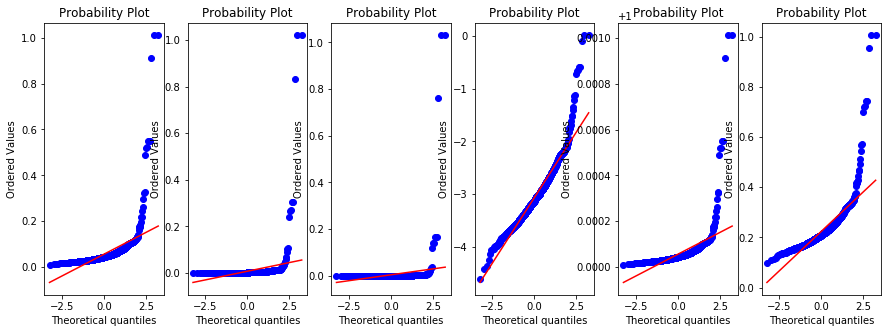

In [20]:
from scipy.stats import probplot

X_k = pd.DataFrame(MinMaxScaler().fit_transform(X_new) + 0.01, columns=X_new.columns)

col = 'f0'
_, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 5))
ax[0] = probplot(X_k[col], plot=ax[0])
ax[1] = probplot((X_k[col]) ** 2, plot=ax[1])
ax[2] = probplot(X_k[col] ** 3, plot=ax[2])
ax[3] = probplot(np.log(X_k[col]), plot=ax[3])
ax[4] = probplot(np.exp(X_k[col]/1000), plot=ax[4])
ax[5] = probplot(np.sqrt(X_k[col]), plot=ax[5]);

Для фичи 'f0' таким преобразованием стало бы логарифмическое.

## Попытки что-то увидеть в эмбеддингах

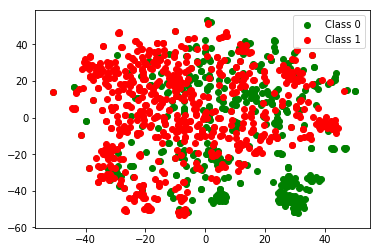

In [22]:
''' Let's apply t-SNE once more '''

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

pipe_pre = Pipeline([('pre_proc', FunctionTransformer(pre_proc, validate=False)),
                      ('drop_zero_var', Drop_zero_var()),
                      ('drop_corr', Drop_corr(threshold=CORR_THRESHOLD)),
                      ('lootme', LOOTME_df(threshold=CAT_THRESHOLD)),
                      ('transform', Find_Trans(threshold=CAT_THRESHOLD)),
                      ('sc', StandardScaler())])

X_pre = pipe_pre.fit_transform(X, y)

tsne = TSNE(random_state=17)
emb_tsne_train = tsne.fit_transform(X_pre)

plt.scatter(emb_tsne_train[y==0, 0], emb_tsne_train[y==0, 1], 
                color='green', marker='o', label='Class 0')
plt.scatter(emb_tsne_train[y==1.0, 0], emb_tsne_train[y==1.0, 1], 
                color='red', marker='o', label='Class 1')
plt.legend()
plt.show();

/Users/A.Miroshnikova/Public/Conda/anaconda3/envs/opencv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


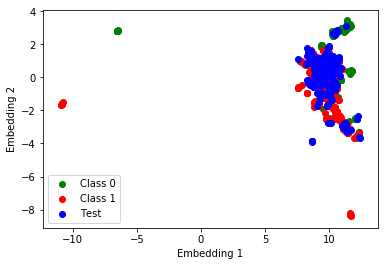

CPU times: user 29.1 s, sys: 1.03 s, total: 30.1 s
Wall time: 30.3 s


In [23]:
%%time
''' And apply UMAP as well '''

from umap import UMAP
from sklearn.preprocessing import StandardScaler

pipe_pre = Pipeline([('pre_proc', FunctionTransformer(pre_proc, validate=False)),
                      ('drop_zero_var', Drop_zero_var()),
                      ('drop_corr', Drop_corr(threshold=CORR_THRESHOLD)),
                      ('lootme', LOOTME_df(threshold=CAT_THRESHOLD)),
                      ('transform', Find_Trans(threshold=CAT_THRESHOLD)),
                      ('sc', StandardScaler())])

X_pre = pipe_pre.fit_transform(X, y)
X_test_pre = pipe_pre.fit_transform(X_test)

umap = UMAP(n_neighbors=5, min_dist=0.2, metric='euclidean', random_state=17,
            n_components=5)

emb_train_umap = umap.fit_transform(X_pre)
emb_test_umap = umap.transform(X_test_pre)

plt.scatter(emb_train_umap[y==0, 0], emb_train_umap[y==0, 1], 
                color='green', marker='o', label='Class 0')
plt.scatter(emb_train_umap[y==1.0, 0], emb_train_umap[y==1.0, 1], 
                color='red', marker='o', label='Class 1')
plt.scatter(emb_test_umap[:, 0], emb_test_umap[:, 1], 
                color='blue', marker='o', label='Test')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.legend()
plt.title('')
plt.show('Plot in UMAP embeddings (first 2 of 5)');

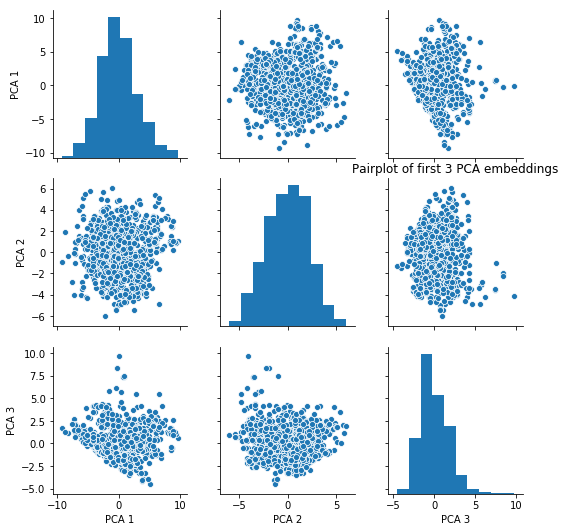

In [24]:
from sklearn.decomposition import PCA

pipe_pre = Pipeline([('pre_proc', FunctionTransformer(pre_proc, validate=False)),
                      ('drop_zero_var', Drop_zero_var()),
                      ('drop_corr', Drop_corr(threshold=CORR_THRESHOLD)),
                      ('lootme', LOOTME_df(threshold=CAT_THRESHOLD)),
                      ('transform', Find_Trans(threshold=CAT_THRESHOLD)),
                      ('PCA', PCA())])

X_pre = pipe_pre.fit_transform(X, y)
X_test_pre = pipe_pre.transform(X_test)

sns.pairplot(pd.DataFrame(X_pre[:, :3], 
                          columns=['PCA 1', 'PCA 2', 'PCA 3']))
plt.title('Pairplot of first 3 PCA embeddings');

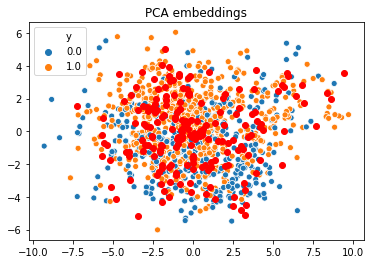

In [25]:
sns.scatterplot(X_pre[:,0], X_pre[:,1], hue=y, cmap='viridis')
plt.scatter(X_test_pre[:,0], X_test_pre[:,1], color='red')
plt.legend()
plt.title('PCA embeddings');

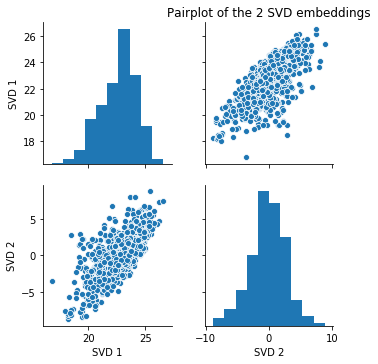

In [26]:
from sklearn.decomposition import TruncatedSVD

pipe_pre = Pipeline([('pre_proc', FunctionTransformer(pre_proc, validate=False)),
                      ('drop_zero_var', Drop_zero_var()),
                      ('drop_corr', Drop_corr(threshold=CORR_THRESHOLD)),
                      ('lootme', LOOTME_df(threshold=CAT_THRESHOLD)),
                      ('transform', Find_Trans(threshold=CAT_THRESHOLD)),
                      ('trSVD', TruncatedSVD(random_state=17))])

X_pre = pipe_pre.fit_transform(X, y)
X_test_pre = pipe_pre.transform(X_test)

sns.pairplot(pd.DataFrame(X_pre, 
                          columns=['SVD 1', 'SVD 2']))
plt.title('Pairplot of the 2 SVD embeddings');

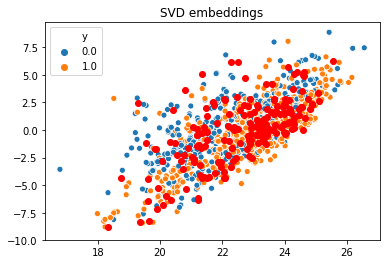

In [27]:
sns.scatterplot(X_pre[:,0], X_pre[:,1], hue=y, cmap='viridis')
plt.scatter(X_test_pre[:,0], X_test_pre[:,1], color='red')
plt.legend()
plt.title('SVD embeddings');

Инсайтов в эмбеддингах не найдено, хотя, может, я просто не умею их готовить -_-)

## Поиск выбросов

In [5]:
%%time

''' Find outliers '''
''' Our inverse covariance matrix is not positive-definite, so we cannot apply Mahalanobis =( '''
''' But we'll definitely try something else. Let's try IsolationForest and OneClassSVM  '''

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

CORR_THRESHOLD = 0.94
CAT_THRESHOLD = 5 # <- and less unique values make feature categorical

def pre_proc(X):
    return fill_inf(replace_na(drop_all_na(X)))

pipe_pre = Pipeline([('pre_proc1', FunctionTransformer(pre_proc, validate=False)),
                      ('drop_zero_var', Drop_zero_var()),
                      ('drop_corr', Drop_corr(threshold=CORR_THRESHOLD)),
                      ('lootme', LOOTME_df(threshold=CAT_THRESHOLD)),
                      ('transform', Find_Trans(threshold=CAT_THRESHOLD))])

X_pre = pipe_pre.fit_transform(X, y)


CPU times: user 13.6 s, sys: 336 ms, total: 13.9 s
Wall time: 12 s


In [6]:
%%time
from sklearn.ensemble import IsolationForest

iso_f = IsolationForest(random_state=17,
                        n_estimators=100,
                        max_features=0.9,
                        contamination=0.05, #
                        n_jobs=-1,
                        behaviour='new')

X_after = pd.DataFrame(iso_f.fit_predict(X_pre), columns=['outlier'],
                       index=X_pre.index)

CPU times: user 1.23 s, sys: 308 ms, total: 1.54 s
Wall time: 1.73 s


In [7]:
X_after['outlier'].groupby(y).value_counts()


y    outlier
0.0   1         386
     -1          38
1.0   1         654
     -1          17
Name: outlier, dtype: int64

In [8]:
%%time
from sklearn.svm import OneClassSVM

oc_svm = OneClassSVM(kernel='poly',
                     nu=0.05,
                     shrinking=True,
                     gamma='scale'
                    )

X_after_oc = pd.DataFrame(oc_svm.fit_predict(X_pre), columns=['outlier'],
                       index=X_pre.index)

CPU times: user 406 ms, sys: 15.8 ms, total: 422 ms
Wall time: 238 ms


In [9]:
X_after_oc['outlier'].groupby(y).value_counts()

y    outlier
0.0   1         388
     -1          36
1.0   1         651
     -1          20
Name: outlier, dtype: int64

OneClassSVM выбрасывает больше, чем IsolationForest. Практически везде использовался IsolationForest.